### Обзор

- Для классификации картинки взял предобученный Resnet50
- Сделал по заданию, ища лицо и делая классификацию уже найденной картинки. Но тут сплошные минусы, во первых, мы не можем вырезать руку с жестом, чтоб классифицировать. А так как мы обучали классификатор на картинках где только руки, то на моменте определения жеста с моей камеры качество не очень. 

In [5]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

In [6]:
batch_size = 200
data_dir = './img'

In [7]:
train_tfms = tt.Compose([tt.ToTensor(),
                         tt.Grayscale(num_output_channels=3), # Картинки чернобелые
                         tt.Resize((256,256)),
                         # Настройки для расширения датасета
                                    # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         
                         tt.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])                      # Приведение к тензору

test_tfms = tt.Compose([tt.ToTensor(), tt.Grayscale(num_output_channels=3), tt.Resize((256,256)),  tt.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

In [8]:

print(os.listdir(data_dir))

['test', 'train']


In [9]:
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
test Classes - ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [10]:
def digit_to_classname(digit):
    if digit == 0:
        return '01_palm'
    elif digit == 1:
        return '02_l'
    elif digit == 2:
        return '03_fist'
    elif digit == 3:
        return '04_fist_moved'
    elif digit == 4:
        return '05_thumb'
    elif digit == 5:
        return '06_index'
    elif digit == 6:
        return '07_ok'
    elif digit == 7:
        return '08_palm_moved'
    elif digit == 8:
        return '09_c'
    elif digit == 9:
        return '10_down'

In [11]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
test_ds = ImageFolder(data_dir + '/test', test_tfms)

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, pin_memory=True)

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


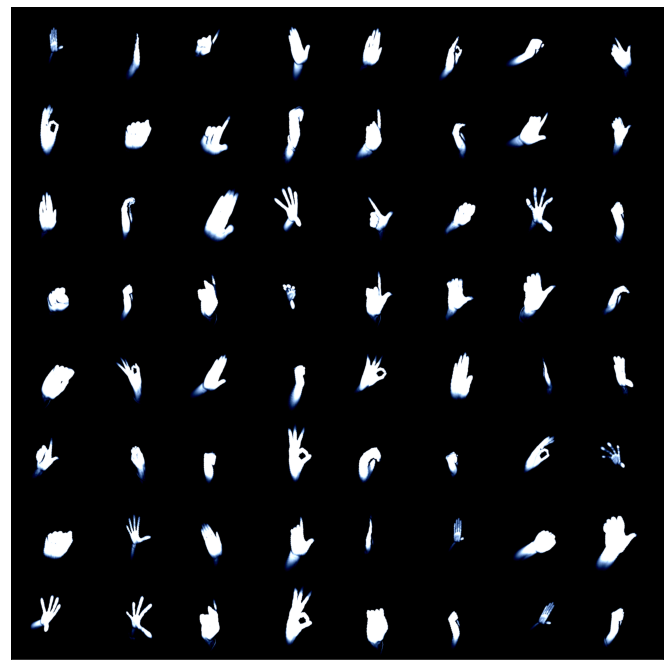

In [15]:
show_batch(train_dl)

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [19]:
from torchvision import models

In [39]:
resnet50 = models.resnet50(pretrained=True)

In [40]:
def set_parameter_requires_grad(model, feature_extracting, learn_layers = 10):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for n, param in enumerate(model.parameters()):
            if n < learn_layers:
                param.requires_grad = False                                

In [41]:
set_parameter_requires_grad(resnet50, False, 150)

In [42]:
resnet50.fc = nn.Linear(2048, 10)

In [43]:
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.0003)
criterion = nn.CrossEntropyLoss()

In [45]:
from time import time
from tqdm import tqdm


def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

In [47]:
print_every = 50
num_epoch = 5

resnet50, train_losses, val_losses = train(
    model=resnet50,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch [1]/[5]. Batch [50]/[81]. Train loss 0.014. Train acc 99.780. Val loss 0.032. Val acc 99.646. Took 126.008 seconds


 20%|████████████████▌                                                                  | 1/5 [03:07<12:30, 187.51s/it]

Epoch took 187.3634693622589
Epoch [2]/[5]. Batch [19]/[81]. Train loss 0.002. Train acc 99.947. Val loss 0.027. Val acc 99.646. Took 61.282 seconds
Epoch [2]/[5]. Batch [69]/[81]. Train loss 0.005. Train acc 99.833. Val loss 0.019. Val acc 99.369. Took 124.689 seconds


 40%|█████████████████████████████████▏                                                 | 2/5 [06:36<10:00, 200.09s/it]

Epoch took 208.75070071220398
Epoch [3]/[5]. Batch [38]/[81]. Train loss 0.002. Train acc 99.921. Val loss 0.028. Val acc 99.470. Took 101.796 seconds


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [09:45<06:30, 195.06s/it]

Epoch took 188.93021845817566
Epoch [4]/[5]. Batch [7]/[81]. Train loss 0.000. Train acc 99.929. Val loss 0.027. Val acc 99.419. Took 36.725 seconds
Epoch [4]/[5]. Batch [57]/[81]. Train loss 0.001. Train acc 99.833. Val loss 0.026. Val acc 98.965. Took 125.182 seconds


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [13:15<03:20, 200.94s/it]

Epoch took 209.79442405700684
Epoch [5]/[5]. Batch [26]/[81]. Train loss 0.000. Train acc 99.962. Val loss 0.017. Val acc 99.874. Took 76.407 seconds
Epoch [5]/[5]. Batch [76]/[81]. Train loss 0.001. Train acc 99.941. Val loss 0.010. Val acc 99.874. Took 124.524 seconds


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [16:45<00:00, 201.01s/it]

Epoch took 209.4675452709198


In [48]:
torch.save(resnet50, './models/emotion_detection_model_state_1_resnet50.pth')

In [49]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN


    
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = torch.load('./models/emotion_detection_model_state_1_resnet50.pth')
        self.emodel.eval()
        self.transf = tt.Compose([tt.ToTensor(), tt.Grayscale(num_output_channels=3), tt.Resize((256,256)),  tt.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

    def _draw(self, frame, boxes, probs, emotion):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, prob in zip(boxes, probs):
                # Draw rectangle on frame
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # Show probability
                cv2.putText(frame, 
                    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

               
        except:
            pass

        return frame
    
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return '01_palm'
        elif digit == 1:
            return '02_l'
        elif digit == 2:
            return '03_fist'
        elif digit == 3:
            return '04_fist_moved'
        elif digit == 4:
            return '05_thumb'
        elif digit == 5:
            return '06_index'
        elif digit == 6:
            return '07_ok'
        elif digit == 7:
            return '08_palm_moved'
        elif digit == 8:
            return '09_c'
        elif digit == 9:
            return '10_down'
       

    def run(self):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                

        while True:
            ret, frame = cap.read()
            try:
                # detect face box, probability and landmarks
                boxes, probs = self.mtcnn.detect(frame, landmarks=False)
                boxes = boxes.astype(int)
                
                face = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                face = self.transf(face)
                face = face.to('cuda')
                emotion = self.emodel(face[None, ...])
                emotion = self.digit_to_classname(emotion.argmax())
                

                # draw on frame
                self._draw(frame, boxes, probs, emotion)

            except:
                pass

            # Show the frame
            cv2.imshow('Face Detection', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        
        


In [50]:
# Run the app
mtcnn = MTCNN()
cap = cv2.VideoCapture(0)  
cap.set(cv2.CAP_PROP_FPS, 1)
fcd = FaceDetector(mtcnn)
fcd.run()